# Exercise 2

This structre of the file is as follows:

1. Imports, functions and constants
2. Data cleaning and filling
3. Describe data
4. Question 3 - Demographic analysis
5. Question 4 - RandomForest predicts valid votes
6. Question 5 - Adaboost predicts votes for parties
7. Question 6 - Minimize disqualified votes 

# Imports, functions and constants

This section was made to make the file a little more organized.

In [190]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans 
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import itertools
import seaborn as sns
from sklearn import decomposition
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import silhouette_score

In [191]:
# Constants
ROOT_PATH = os.path.abspath(os.getcwd())
SEED = 170
VOTES_THRESHOLD = 135720

# bycode 2018 excel
BYCODE = os.path.join(ROOT_PATH,"bycode2018.xlsx")

# index 2018 excel
INDEX = os.path.join(ROOT_PATH,"index 2018.xlsx")

# sheets in index 2018
NATURAL = "Natural Area"
DISTRICT = "District"
RELIGION = "Religion"
SETTLEMENT_TYPE = "Settlement type"


# elections data
SETTELMENT21 = os.path.join(ROOT_PATH,"21settelments.xlsx")
SETTELMENT22 = os.path.join(ROOT_PATH,"22settelments.xlsx")
SETTELMENT23 = os.path.join(ROOT_PATH,"23settelments.xlsx")

CALPI21 = os.path.join(ROOT_PATH,"21calpi.xlsx")


In [192]:
def inner_join(df_1,df_2,column_name):
    """makes inner-join between dataframes on the specified column"""
    return pd.merge(left=df_1, right=df_2, left_on= column_name, right_on=column_name)

def remove_small_parties(df,threshold):
    """remove parties that didnt pass the threshold"""
    
    for column in df.columns[7:]:
            if df[column].sum() < threshold:
                   df = df.drop(column,axis=1)
    return df

def unite_parties (df):
    """ unites small parties to factions
    
    We think those factions represent the israeli society
    """
    
    d={'United Torah Judaism':'Haredi','Shas':'Haredi', 'Avoda':'Left','Meretz':'Left',
       'Consolidation of right-wing parties':'Right','Kolano':'Right','Israel is our Home':'Right','New Right':'Right',
        'UAL-Balad':'Arab','Hadash':'Arab' ,'Gesher Avoda':'Left','Joint list':'Arab','right':'Right'
        ,'Avoda-Meretz-Gesher':'Left'}
    
    faction=['Haredi','Right','Arab','Left']
    for f in faction:
        df.insert(len(df.columns),f ,0)
    for c in  df.columns[7:]:
        if c in d:
            s=df[d[c]]+df[c]
            df[d[c]]=s
   
    for c in d.keys():
        if c in df.columns:
              df=df.drop(c,axis=1)
    return df

def normalize_to_voting_ratios(df_original):
    """normalizing the votes according to proportion of votes per party"""
   
    columns = ['Haredi','Right','Arab','Left','Likud','Blue and white']
    df = df_original.copy()
    df = df[columns].astype(float)
    
    
    for i,r in df_original.iterrows():
        for c in columns:
            x = r[c]/r['valid votes']
            df.at[i , c]=x
            
    return df[columns]

def add_most_voted_colm(df):
    """ adds a column of labels for the most voted faction """
    temp = df.copy()
    temp = temp[['Haredi','Right','Arab','Left','Likud','Blue and white']]
    
    for c in temp.columns:
        temp[c] = pd.to_numeric(temp[c])
    
    colm = temp.idxmax(axis=1)
    df["chosen"] = colm
    return df
        

In [193]:
def barchar_group(df,x_var,groupby_var,size,name):
    """creates a barchar that represents aggregation results"""
    
    df_agg = df.loc[:, [x_var, groupby_var]].groupby(groupby_var)
    vals = [df[x_var].values.tolist() for i, df in df_agg]

    # Draw
    plt.figure(figsize=(16,9), dpi= 80)
    colors = [plt.cm.Spectral(i/float(len(vals)-1)) for i in range(len(vals))]
    n, bins, patches = plt.hist(vals, df[x_var].unique().__len__(), stacked=False, density=False, color=colors[:len(vals)])

    # Decoration
    plt.legend({group:col for group, col in zip(np.unique(df[groupby_var]).tolist(), colors[:len(vals)])})
    plt.title(name, fontsize=22)
    plt.xlabel(x_var)
    plt.ylabel("Frequency")
    plt.ylim(0, size)
    plt.xticks(ticks=bins, labels=np.unique(df[x_var]).tolist(), rotation=90, horizontalalignment='left')
    plt.show()

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)
    
def pca_conversion(vectors):
    """ PCA conversion for visualiztion"""
    pca = decomposition.PCA(n_components=3)
    pca.fit(vectors)
    vectors_vis = pca.transform(vectors)
    vectors_vis = pd.DataFrame(vectors_vis,columns = ["x","y","z"])
    return vectors_vis

# Data cleaning and filling

### Remove irevelant columns and rows

I will be removing columns and rows that might make my data too noise or just have insufficent infomration about them.

1. year - column that has only one value 2018 which means when 
2. rows with NA values as names will be removed, probabliy very small communitiues that has no real impact on the signal in the data
3. Montzifali Status - This column is 
4. Metropolitan association - We dont believe that the way people vote is effected by the Metroplin they are in.


In [194]:
bycode = pd.read_excel(BYCODE,dtype=object)
bycode.drop("year",axis = 1,inplace = True)
bycode.drop("Metropolitan association",axis = 1,inplace = True)


bycode =bycode[bycode["name"].str.contains("NA") == False]
bycode.drop("name",axis=1, inplace = True)
bycode.drop("Status Montzifali",axis=1,inplace=True)

### Fill  columns
We are filling the dataframe with values that we believe are logical and important to make the correct analysis.

* **Established** - column represents year that the settelment was established, we use the most frequent value to fill the gaps
* **Total population in 2018** - column represents the amount of people living in the settelment, we fill the gaps with the median of the values in this column

* **Arabs/Thereof: Jews/Jews and others** - column represents the amount of people living in the settelment by national, the gaps are filled according to settelment type. if Arab settelment then everyone is from arab national if Jewish settelment then everyone is from Jewish national

* **height** - column represents the height of the settelment, we fill it with most frequent value in the column.

* **Organizational affiliation code** - column represents the organiztion the settelment belongs to, we put a dummie value "19" to fill gaps

* **Natural area code** - column represents the area of the settelemnt, gaps are filled according to the district they belong to

* **Local authorities code** - column represents the authorities that

* **Religion code** - column reprsents the religion of settelment, gaps are filled according to the national of the settelment

In [195]:
# fill established with most frequent year
bycode["Established"] = pd.to_numeric(bycode["Established"],errors='coerce')
bycode["Established"] = bycode["Established"].fillna(bycode["Established"].value_counts().idxmax())
bycode["Established"] = bycode["Established"].astype(int)

#fill total popluation with median population
bycode["Total population in 2018"] = pd.to_numeric(bycode["Total population in 2018"],errors='coerce')
bycode["Total population in 2018"] = bycode["Total population in 2018"].fillna(bycode["Total population in 2018"].median())
bycode["Total population in 2018"] = bycode["Total population in 2018"].astype(int)

#fill arabs, jews, and other
arabs_code = [250,260,270,280,290,440,450,460]

for index,row in bycode.iterrows():

    if row['Settlement type code'] in arabs_code and pd.isnull(row['Jews and others']):
        bycode.at[index,"Jews and others"] = "0"
        bycode.at[index,"Thereof: Jews"] = "0"
        bycode.at[index,"Arabs"] = row["Total population in 2018"]

    elif row['Settlement type code'] not in arabs_code and pd.isnull(row['Jews and others']):
        bycode.at[index,"Jews and others"] = row["Total population in 2018"]
        bycode.at[index,"Thereof: Jews"] = row["Total population in 2018"]
        bycode.at[index,"Arabs"] = "0"


bycode["Arabs"].fillna("0",inplace = True)
bycode["Thereof: Jews"].fillna("0",inplace = True)
bycode["Jews and others"].fillna("0",inplace = True)

# fill height
bycode["height"].fillna(bycode["height"].value_counts().idxmax(),inplace = True)   

#fill Organizational affiliation
bycode["Organizational affiliation code"].fillna("19",inplace = True)

#fill Natural area code
for index,row in bycode.iterrows():
    if  pd.isnull(row['Natural area code']):
        if row["District code"] == 11:
            bycode.at[index,"Natural area code"] = "111"
        elif row["District code"] in [21,22,23,24,25,29]:
            bycode.at[index,"Natural area code"] = "211"
        elif row["District code"] == [31,32]:
            bycode.at[index,"Natural area code"] = "311"
        elif row["District code"] == [41,42,43,44]:
            bycode.at[index,"Natural area code"] = "411"
        elif row["District code"] == [51,52,53]:
            bycode.at[index,"Natural area code"] = "511"
        elif row["District code"] == [61,62]:
            bycode.at[index,"Natural area code"] = "611"
        
        else:
            bycode.at[index,"Natural area code"] = "0"

#fill Local authorities
bycode["Local authorities code"].fillna(0,inplace = True)

# fill Religion
for index,row in bycode.iterrows():
    if pd.isnull(row['Religion code']):
        if row["Arabs"] == "0":
            bycode.at[index,"Religion code"] = "1"
        else:
            bycode.at[index,"Religion code"] = "2"
            
            
bycode.astype(float,copy=False)
bycode.fillna(0,inplace = True)

In [196]:
def total_voters(df):
    "ploting a barchar from dataframe"
    dict={}
    for c in df.columns[7:]:
        dict[c]=(df[c].sum()/df['valid votes'].sum())*100
    plt.figure(figsize=(20,10))
    plt.bar(range(len(dict)), list(dict.values()), align='center')
    plt.ylabel('Voter turnout')
    plt.xlabel('Parties')
    plt.xticks(range(len(dict)), list(dict.keys()))
    plt.show()

# Describe data

### index 2018
This excel just translates the codes from bycode.xlsx to relevant labels 

In [197]:
df = pd.read_excel(INDEX)
df

,Subdistrict,District,Subdistrict code
0,Jerusalem,Jerusalem,11
1,Zefat,North,21
2,Kinneret,North,22
3,Jezreel,North,23
4,Acre,North,24
5,Jezreel,North,25
6,Golan,North,29
7,Haifa,Haifa,31
8,Hadera,Haifa,32
9,Hasharon,Center,41


### bycode

This excel contains observations on settelments 

In [198]:
bycode

,code,District code,Subdistrict code,Natural area code,Religion code,Total population in 2018,Jews and others,Thereof: Jews,Arabs,Established,Settlement type code,Organizational affiliation code,Coordinates,height,Planning Commission,Space Police code,Local authorities code
0,967,6,62,623,3,832,0,0,832,1949,460,19,2040057100,50,699,15003711,0
1,472,1,11,111,2,7543,97,79,7446,1949,280,19,2105263481,598,152,10002475,0
3,935,6,62,623,3,832,0,0,832,1949,460,19,1865057450,50,699,10001937,0
4,958,6,62,623,3,832,0,0,832,1949,460,19,1850057900,50,699,10001937,0
5,1042,6,62,623,3,832,0,0,832,1949,460,19,1950056700,50,699,15003711,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1477,665,6,62,621,1,699,699,699,0,1949,310,2,1600359560,109,651,10001930,620
1478,3563,7,76,0,1,3882,3880,3840,2,1977,190,19,2218961753,566,714,15000586,0
1479,970,6,62,623,3,832,0,0,832,1949,460,19,1830056400,50,699,10001946,0
1480,1346,6,62,623,2,1089,6,6,1083,1949,450,19,1752658369,210,624,10001946,610


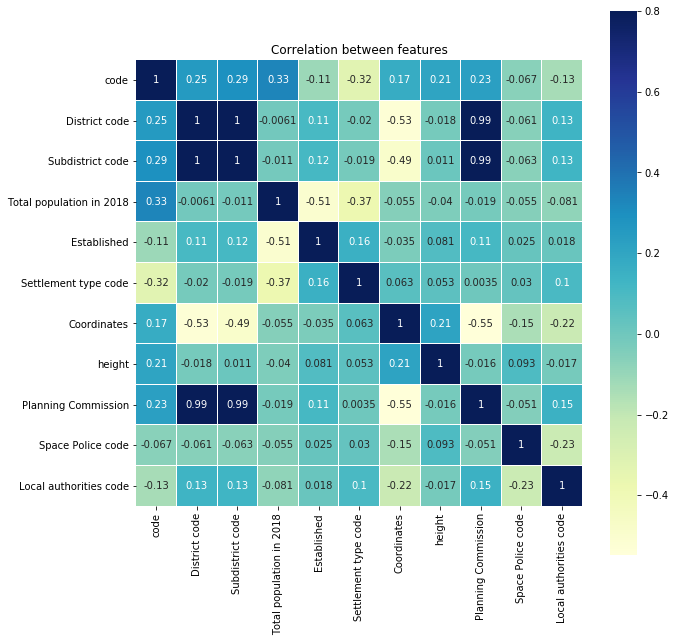

In [199]:
corr=bycode.corr()
plt.figure(figsize=(10, 10))

sns.heatmap(corr, vmax=.8, linewidths=0.01,
            square=True,annot=True,cmap='YlGnBu',linecolor="white")
plt.title('Correlation between features');

### 21settelments

Example for settlements file

In [200]:
df = pd.read_excel(SETTELMENT21,dtype=object)
df.drop("name",axis = 1, inplace = True)
df

,committee code,code,Holders of voting rights,Voters,Disqualified,valid votes,Avoda,United Torah Judaism,UAL-Balad,Hadash,...,social justice,Green economy,Ofek Hadash,Me and you,Justice for all,Our Land of Israel,at first,All Israeli brothers and action in Israel,Arab List,Shas
0,17,7,516,371,0,371,17,2,0,0,...,0,0,0,0,0,0,0,0,0,33
1,2,10,333,237,2,235,4,3,0,0,...,0,0,0,0,0,0,0,0,0,73
2,17,11,403,289,1,288,21,0,0,0,...,0,0,0,0,0,0,0,0,0,2
3,18,13,502,403,0,403,44,2,0,0,...,0,0,0,0,3,0,0,0,0,2
4,17,15,302,217,2,215,1,4,0,0,...,0,0,0,0,0,0,0,0,0,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1209,8,9500,34220,22168,157,22011,925,214,3,9,...,21,4,0,1,27,9,1,8,4,471
1210,8,9600,36506,21114,227,20887,450,123,7,6,...,17,6,0,1,29,9,5,5,18,547
1211,19,9700,45512,34904,104,34800,2652,154,6,38,...,25,2,0,1,34,2,5,2,0,555
1212,9,9800,10073,7652,27,7625,745,13,6,18,...,10,0,0,0,4,0,0,0,1,78


### calpi21

Example for calpi file

In [201]:
df = pd.read_excel(CALPI21,dtype=object)
df.drop("name",axis=1,inplace=True)
df

,code,calpi_num,Holders of voting rights,Voters,Disqualified,valid votes,Avoda,United Torah Judaism,UAL-Balad,Hadash,...,social justice,Green economy,Ofek Hadash,Me and you,Justice for all,Our Land of Israel,at first,All Israeli brothers and action in Israel,Arab List,Shas
0,967,1,546,64,2,62,2,0,31,7,...,0,0,0,0,0,0,1,0,0,0
1,967,2,739,113,2,111,2,0,69,5,...,0,0,0,0,0,2,0,0,0,0
2,967,3,630,98,1,97,1,0,75,1,...,0,0,0,0,0,0,0,0,0,0
3,472,1,518,197,6,191,4,0,36,50,...,0,1,0,0,1,0,0,0,0,1
4,472,2,679,290,3,287,7,0,69,85,...,0,0,0,0,0,0,0,1,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10760,3563,2,646,498,0,498,5,10,0,0,...,0,0,0,0,0,0,0,0,0,6
10761,3563,3,690,568,1,567,5,2,0,0,...,0,0,0,0,0,0,0,0,0,8
10762,970,1,496,26,0,26,1,0,11,0,...,0,0,0,0,0,0,0,0,0,1
10763,1346,1,567,143,2,141,0,0,47,9,...,0,0,0,0,5,0,0,1,0,0


# Question 3 - Demographic analysis

Assumptions used:
1. Small parties - that doesnt pass the vote threshold are not representative enough to be considered in the analysis
2. Union of parties - we unite parties with the same political agenda except "Blue and white" and "Likud"
    * **Haredi** - parties that represnt the Hardi communities in israel
    * **Right** - parties that have a right wing politcal agenda
    * **Left** - parties that have a left wing politcal agenda
    * **Arab** - parties that represnt the Arab communities in israel
3. Every settlemnet has a representative party, the one which was voted the most in this settlement 


This way which we approach this problem is by normalizing the dataframe according to the total number of votes that were made in each settelment. By normalizing we get a vector which represents the behavoiur in which the settelment is voting. In this way a large city like jerusalem  can get the same vector as a small kibbutz.

After the normaliziation we start the clustering process and analyze the different clusters created.

In [202]:
index = pd.read_excel(INDEX,sheet_name=SETTLEMENT_TYPE)
df_21 = pd.read_excel(SETTELMENT21,dtype=object)

# using assumptions
df_21 = remove_small_parties(df_21,VOTES_THRESHOLD)
df_21 = unite_parties(df_21)
df_21 = add_most_voted_colm(df_21)

# inner joins to add the settelment type to every settelment observation
df_21 = inner_join(df_21,bycode,"code")
df_21 = inner_join(df_21,index,"Settlement type code")
df_21.fillna(0,inplace = True)

df_base = df_21[["Likud","Blue and white",'Haredi','Right','Arab','Left',"chosen","Settlement type","valid votes"]]

#### Exploring the dataframe created

In the coorelation matrix there is a little signal that show that  "Blue and White" correlations are very similar to  "Left" correlations.  

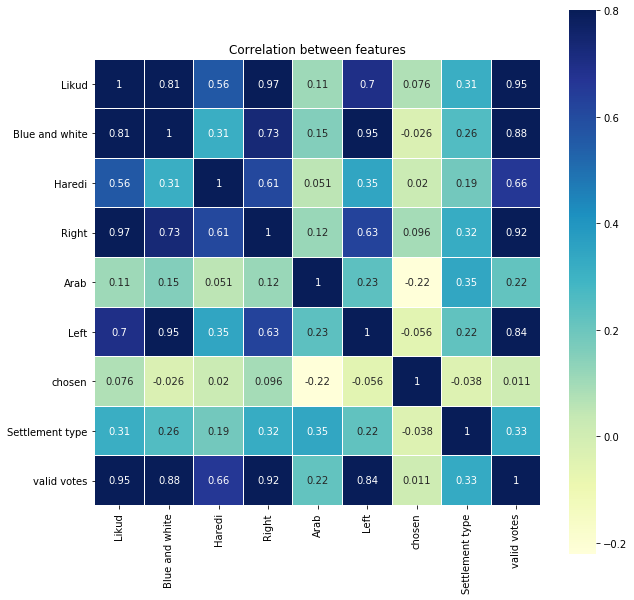

In [203]:
# preparing dataframe for visualiztion
le = LabelEncoder()
df = df_base.copy()
df['Settlement type'] = le.fit_transform(df['Settlement type'])
df["chosen"] = le.fit_transform(df['chosen'])
df = df.astype(int)

# plot corrleation matrix
corr=df.corr()
plt.figure(figsize=(10, 10))

sns.heatmap(corr, vmax=.8, linewidths=0.01,
            square=True,annot=True,cmap='YlGnBu',linecolor="white")
plt.title('Correlation between features');

In [204]:
# normalizing vectors
df_normalized = normalize_to_voting_ratios(df_base)

# Using PCA to convert the vectors to 3D representation
vectors_vis = pca_conversion(df_normalized)

It is possible to see that there are some clusters in this 3D plot

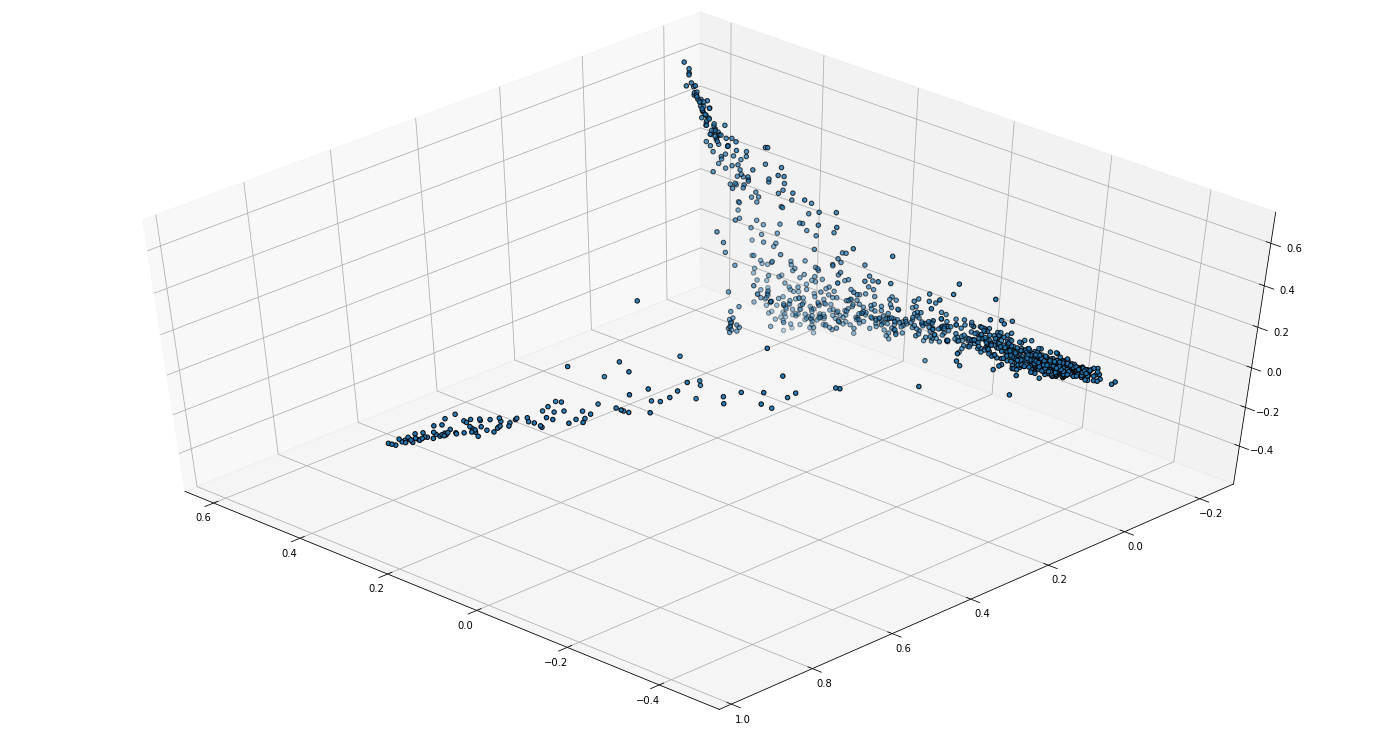

In [205]:
fig = plt.figure(figsize=(20,10))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

ax.scatter(vectors_vis["x"], vectors_vis["y"], vectors_vis["z"], cmap=plt.cm.nipy_spectral,
           edgecolor='k')

### Kmeans

Use case: General-purpose, even cluster size, flat geometry, not too many clusters

Geometry: Distances between points

Evaluation metric:
1. Elbow method  - computes the sum of squared distances from each point to its assigned center.  
2. Silhouette score -  silhouette value is a measure of how similar an object is to its own cluster compared to other clusters

In case the Elbow method is not informative enough we will base our desicion according Silhouette score. 

In [206]:
Sum_of_squared_distances = []
sil  = []
K = range(2,6)

for k in K:
    km = KMeans(n_clusters=k)
    km.fit(df_normalized)
    Sum_of_squared_distances.append(km.inertia_)
    labels = km.labels_
    sil.append(silhouette_score(df_normalized, labels, metric = 'euclidean'))

Elbow method is not informative enough,the angle in which the graph is going is quit consistent

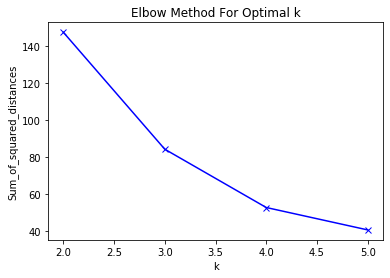

In [207]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

We choose K that gives us the highest score for silhouette 

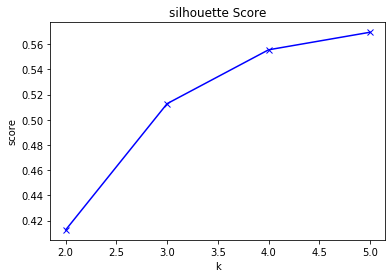

In [208]:
plt.plot(K, sil, 'bx-')
plt.xlabel('k')
plt.ylabel('score')
plt.title('silhouette Score')
plt.show()

### Using Kmeans

In this point we are using kmeans with k=5 and add "Cluster Class" column to our base dataframe and the visualization dataframe.

In [228]:
km = KMeans(n_clusters=5)
km.fit(df_normalized)
y = km.predict(df_normalized)

df_base['Cluster Class'] = pd.Series(y, index=df_base.index)
vectors_vis['Cluster Class'] = pd.Series(y, index=df_normalized.index)

C:\Users\gabi9\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



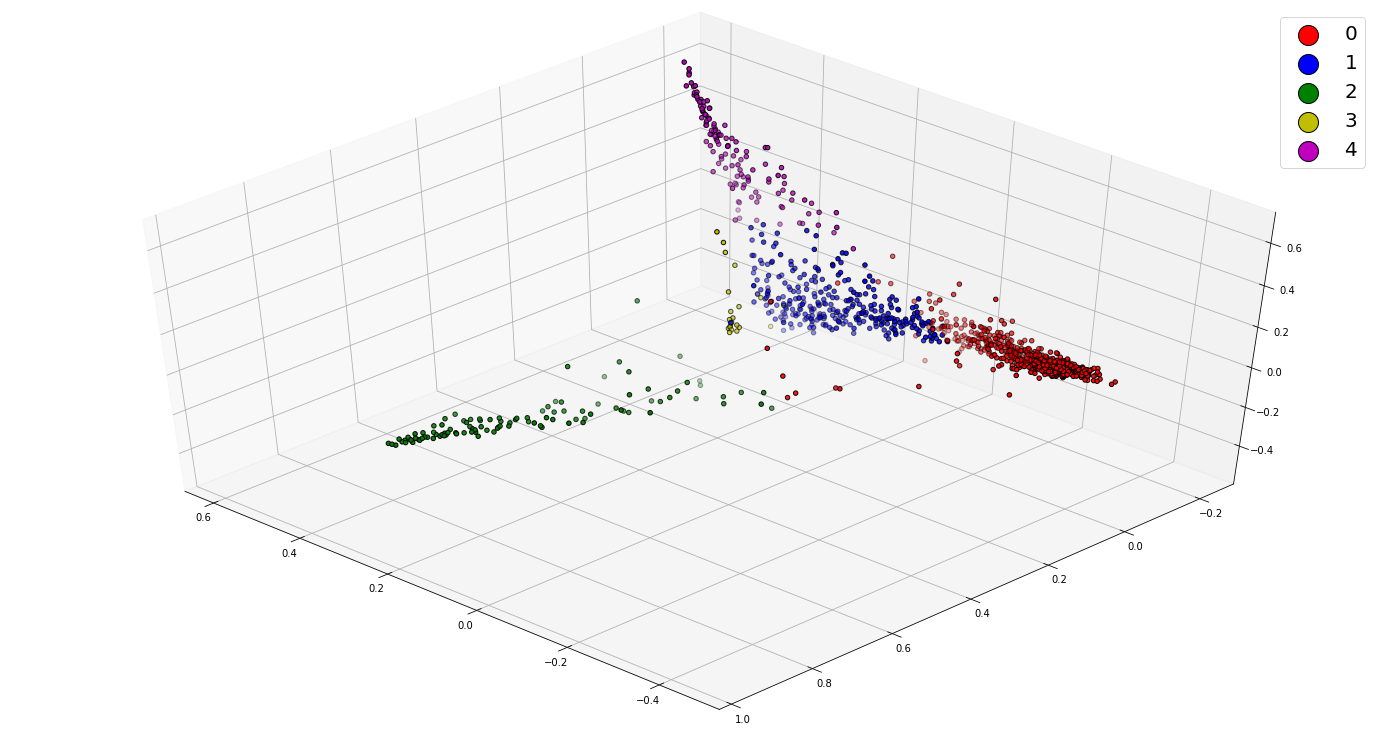

In [229]:
df = vectors_vis.groupby('Cluster Class')

fig = plt.figure(figsize=(20,10))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

colors = itertools.cycle(["r", "b", "g","y","m"])

for name,cluster in df:
    ax.scatter(cluster["x"], cluster["y"], cluster["z"], cmap=plt.cm.nipy_spectral,c=next(colors),
           edgecolor='k',label=name)

lgnd = plt.legend(prop={'size': 20})

#change the marker size manually for both lines
for legendHandle in lgnd.legendHandles:
    legendHandle._sizes = [400]

### Analyzing kmeans results

We make two aggregation:
1. We count representative parties in each cluster
2. We count the different types of settelments in each cluster

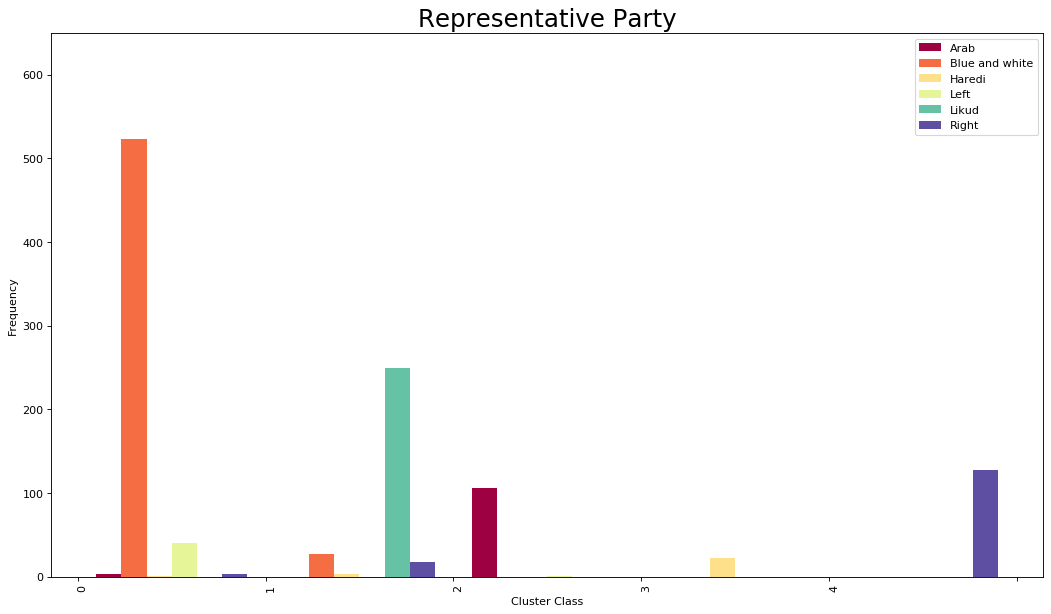

In [230]:
barchar_group(df_base,"Cluster Class","chosen",650,"Representative Party")

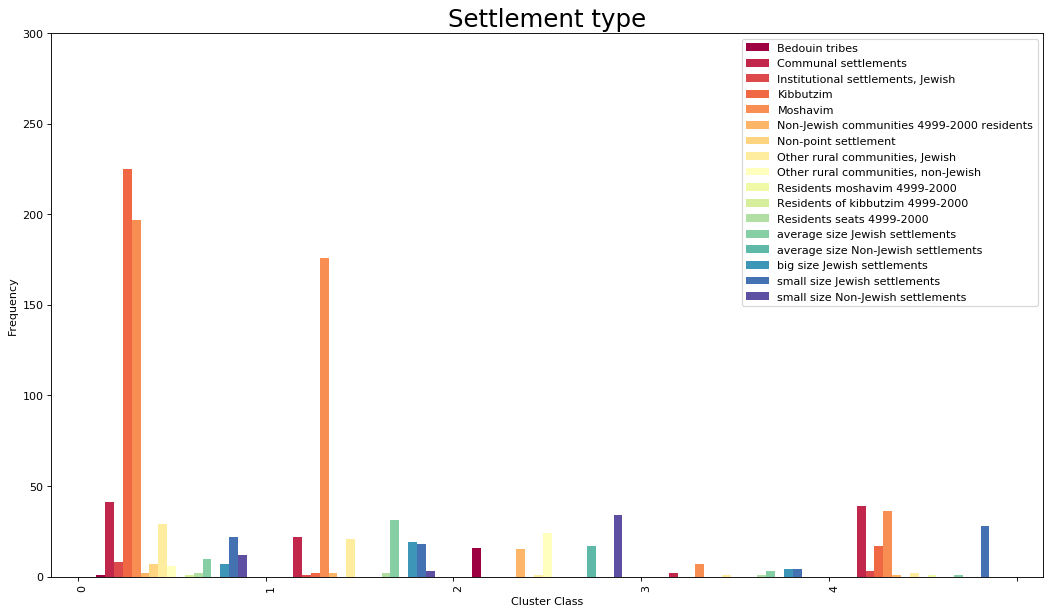

In [231]:
barchar_group(df_base,"Cluster Class","Settlement type",300, "Settlement type")

In [213]:
from sklearn import mixture

lowest_bic = np.infty
bic = []
n_components_range = range(1, 5)
cv_types = ['spherical', 'tied', 'diag', 'full']

for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type)
        gmm.fit(df_normalized)
        bic_score = gmm.bic(df_normalized)
        if bic_score < lowest_bic:
            lowest_bic = bic_score
            best_gmm = gmm

y = gmm.predict(df_normalized)
df_base['Cluster Class'] = pd.Series(y, index=df_base.index)
vectors_vis['Cluster Class'] = pd.Series(y, index=df_normalized.index)

C:\Users\gabi9\anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



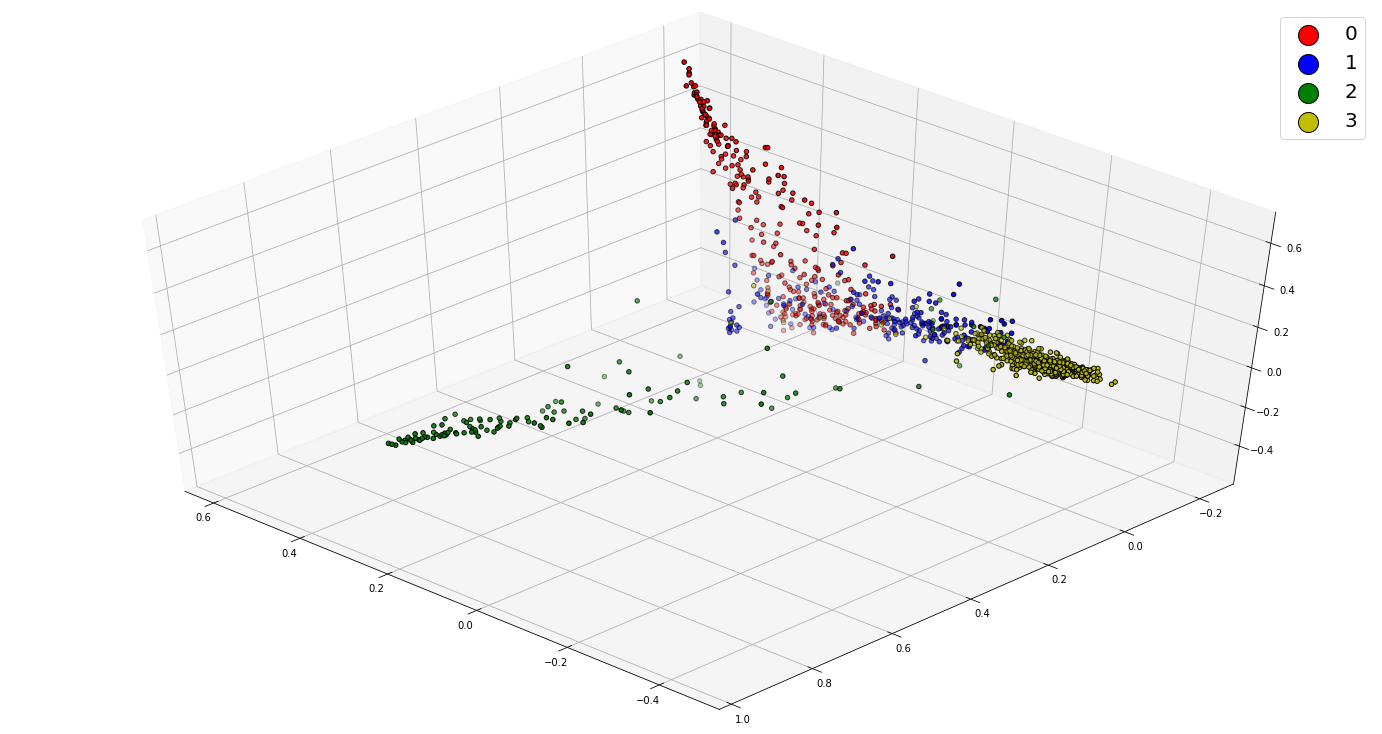

In [214]:
df = vectors_vis.groupby('Cluster Class')

fig = plt.figure(figsize=(20,10))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

colors = itertools.cycle(["r", "b", "g","y","m"])

for name,cluster in df:
    ax.scatter(cluster["x"], cluster["y"], cluster["z"], cmap=plt.cm.nipy_spectral,c=next(colors),
           edgecolor='k',label=name)

lgnd = plt.legend(prop={'size': 20})

#change the marker size manually for both lines
for legendHandle in lgnd.legendHandles:
    legendHandle._sizes = [400]

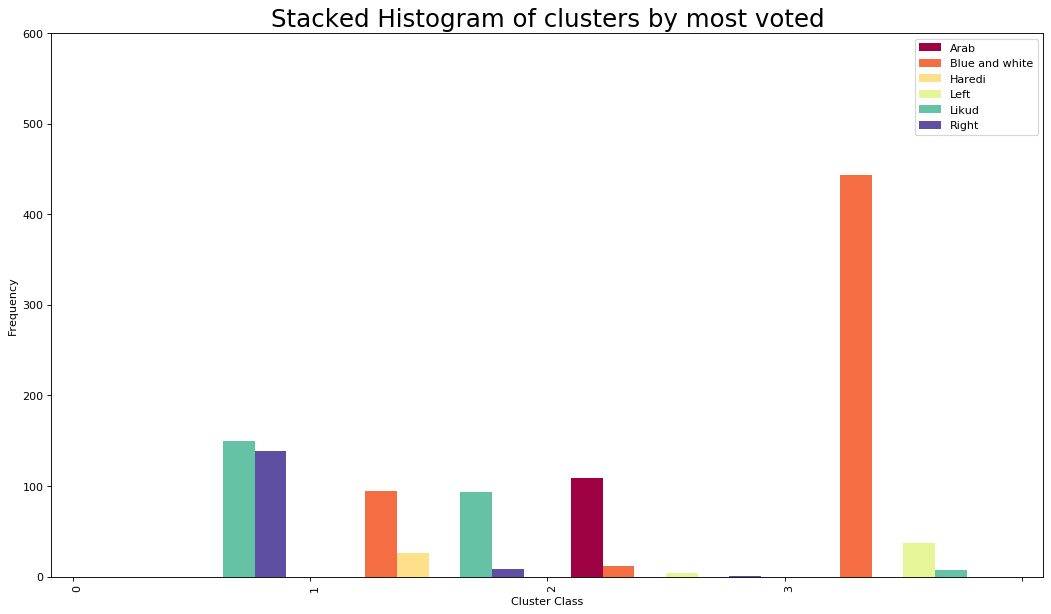

In [215]:
barchar_group(df_base,"Cluster Class","chosen",600,"Stacked Histogram of clusters by most voted")

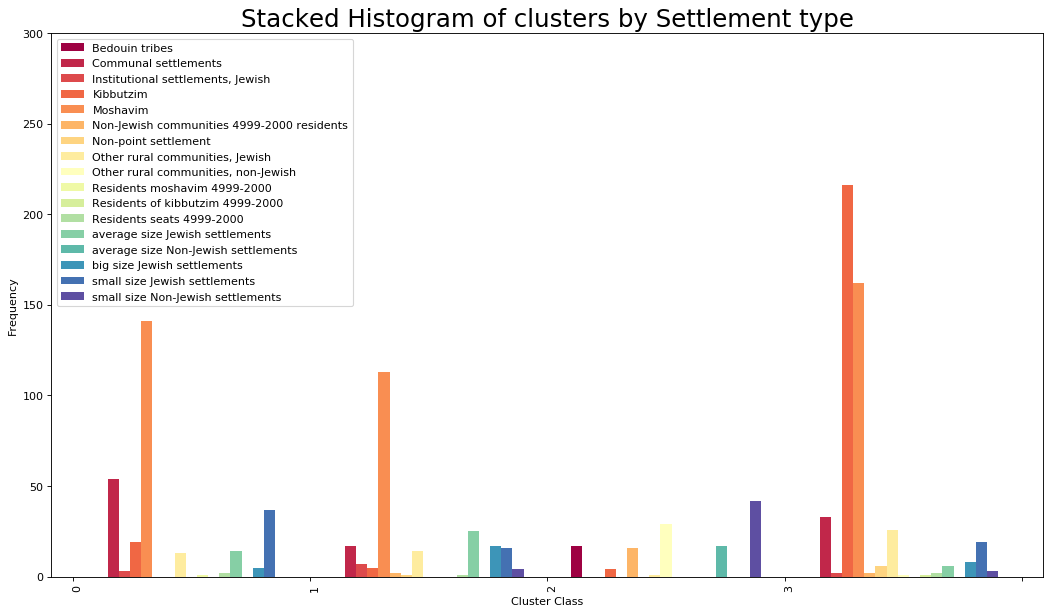

In [216]:
barchar_group(df_base,"Cluster Class","Settlement type",300,"Stacked Histogram of clusters by Settlement type")

# Question 4

In [217]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import  RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'n_estimators': [100, 150, 200, 250],  # The number of trees in the forest.
    'max_depth': [None, 50, 60, 70],  # The maximum depth of the tree.
    'max_features': ['sqrt', None,'log2'],  # he number of features to consider when looking for the best split
    'min_samples_split': [2, 5, 10],  # The minimum number of samples required to split an internal node
    'bootstrap': [True, False]  # Whether bootstrap samples are used when building trees.
}


df21 = pd.read_excel(SETTELMENT21)
df22 = pd.read_excel(SETTELMENT22)
df23 = pd.read_excel(SETTELMENT23)

features = np.delete(bycode.columns,np.where(bycode.columns== "code"))
target = "valid votes"

df21 = inner_join(bycode,df21,"code")
df22 = inner_join(bycode,df22,"code")
df23 = inner_join(bycode,df23,"code")

df_train = pd.concat([df21, df22])

TEST=["HAIFA","ELAT","AYYELET HASHAHAR","SAKHNIN","QAZRIN"]
df_test = df23[df23.name.isin(TEST)]
locations=df_test['name'].values.tolist()

# preparing data for training and testing
x_train = df_train[features]
y_train = df_train[target]

x_test = df_test[features]
y_test = df_test[target]

# selecting features according to importance and transformig data accordingly
sfm = SelectFromModel(RandomForestRegressor())
sfm.fit(x_train, y_train)
x_train = sfm.transform(x_train)
x_test = sfm.transform(x_test)


# trainning model and testing
rs = GridSearchCV(RandomForestRegressor(random_state=SEED), param_grid, n_jobs=-1,
                        scoring='neg_mean_absolute_error', cv=5,
                        verbose=1)
rs.fit(x_train,y_train)
predict_y = rs.predict(x_test)

pred = pd.DataFrame(predict_y,columns=["prediction"],index = locations)
test = pd.DataFrame(y_test.values,columns=["actual"],index = locations)
        
results =  pd.concat([pred,test], axis=1)
results

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   32.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:  4.6min finished


,prediction,actual
AYYELET HASHAHAR,580.0,585
ELAT,22699.0,22636
HAIFA,144310.0,144625
SAKHNIN,15833.0,17085
QAZRIN,3483.5,3498


In [218]:
import plotly.graph_objects as go

fig = go.Figure(data=[
    go.Bar(name='Test', x=results.index, y=results['actual'],  textposition='auto', 
           marker_color='rgb(255,51,51)', marker_line_color='rgb(8,48,107)',marker_line_width=1, opacity=0.6),
    go.Bar(name='Pred', x=results.index, y=results['prediction'],  textposition='auto',
           marker_color='rgb(102,178,255)', marker_line_color='rgb(30,70,70)',marker_line_width=1, opacity=0.6)
])

# Change the bar mode
fig.update_layout(barmode='group', xaxis_tickangle=-45)
fig.update_layout(title_text='Comparison between prediction and actual data', xaxis_title="Settlements",
    yaxis_title="Number of votes",)
fig.show()

# Question 5

In [219]:
from sklearn import  metrics
from sklearn.ensemble import AdaBoostRegressor
from sklearn.feature_selection import RFECV


adb_param_grid = {'n_estimators':[50,100,150,200,250], #Number of weak learners to train iteratively., 
                  'learning_rate':[0.001, 0.01, 0.1, 1], #It contributes to the weights of weak learners. It uses 1 as a default value.,
                  'random_state': [1]}


# preparing data
df21 = pd.read_excel(SETTELMENT21)
df21 = remove_small_parties(df21,135720)
df21 = unite_parties(df21)

df22 = pd.read_excel(SETTELMENT22)
df22 = remove_small_parties(df22,135720)
df22 = unite_parties(df22)

df23 = pd.read_excel(SETTELMENT23)
df23 = remove_small_parties(df23,135720)
df23 = unite_parties(df23)

features = np.delete(bycode.columns,np.where(bycode.columns== "code"))

df21 = inner_join(bycode,df21,"code")
df22 = inner_join(bycode,df22,"code")
df23 = inner_join(bycode,df23,"code")

df_train = pd.concat([df21, df22])

cities=["JERUSALEM","BENE BERAQ","SAKHNIN","KARMI'EL","DALIYAT AL-KARMEL"]
df_test = df23[df23.name.isin(cities)]

### Likud votes prediction

In [220]:
# model for likud
target = "Likud"

x_train = df_train[features]
y_train = df_train[target]

x_test = df_test[features]
y_test = df_test[target]


sfm = SelectFromModel(AdaBoostRegressor())
sfm.fit(x_train, y_train)
x_train = sfm.transform(x_train)
x_test = sfm.transform(x_test)

gsADB = GridSearchCV(AdaBoostRegressor(),param_grid = adb_param_grid, cv=5, scoring="neg_root_mean_squared_error", n_jobs= -1)
gsADB.fit(x_train,y_train)

adb = gsADB.best_estimator_

y_predict = adb.predict(x_test)
print(metrics.mean_squared_error(y_test,y_predict))

pred = pd.DataFrame(y_predict,columns=["prediction"],index = cities)
test = pd.DataFrame(y_test.values,columns=["actual"],index = cities)
        
results =  pd.concat([pred,test], axis=1)
results


20782846.93918047


,prediction,actual
JERUSALEM,4234.113924,4951
BENE BERAQ,437.000000,407
SAKHNIN,62470.833333,72601
KARMI'EL,8091.136842,8879
DALIYAT AL-KARMEL,437.000000,39


In [221]:
import plotly.graph_objects as go

fig = go.Figure(data=[
    go.Bar(name='Test', x=results.index, y=results['actual'],  textposition='auto', 
           marker_color='rgb(255,51,51)', marker_line_color='rgb(8,48,107)',marker_line_width=1, opacity=0.6),
    go.Bar(name='Pred', x=results.index, y=results['prediction'],  textposition='auto',
           marker_color='rgb(102,178,255)', marker_line_color='rgb(30,70,70)',marker_line_width=1, opacity=0.6)
])

# Change the bar mode
fig.update_layout(barmode='group', xaxis_tickangle=-45)
fig.update_layout(title_text='Comparison between prediction and actual data',
    yaxis_title="Number of votes",)
fig.show()

### Blue and White predictions

In [222]:
# model for Blue and White
target = "Blue and white"

x_train = df_train[features]
y_train = df_train[target]

x_test = df_test[features]
y_test = df_test[target]


sfm = SelectFromModel(AdaBoostRegressor())
sfm.fit(x_train, y_train)
x_train = sfm.transform(x_train)
x_test = sfm.transform(x_test)

gsADB = GridSearchCV(AdaBoostRegressor(),param_grid = adb_param_grid, cv=5, scoring="neg_root_mean_squared_error", n_jobs= -1)
gsADB.fit(x_train,y_train)

adb = gsADB.best_estimator_

y_predict = adb.predict(x_test)
print(metrics.mean_squared_error(y_test,y_predict))


pred = pd.DataFrame(y_predict,columns=["prediction"],index = cities)
test = pd.DataFrame(y_test.values,columns=["actual"],index = cities)
        
results =  pd.concat([pred,test], axis=1)
results

19063945.43631798


,prediction,actual
JERUSALEM,9363.376559,1133
BENE BERAQ,564.878049,5200
SAKHNIN,30571.400000,32800
KARMI'EL,5661.754464,6627
DALIYAT AL-KARMEL,564.878049,120


In [223]:
import plotly.graph_objects as go

fig = go.Figure(data=[
    go.Bar(name='Test', x=results.index, y=results['actual'],  textposition='auto', 
           marker_color='rgb(255,51,51)', marker_line_color='rgb(8,48,107)',marker_line_width=1, opacity=0.6),
    go.Bar(name='Pred', x=results.index, y=results['prediction'],  textposition='auto',
           marker_color='rgb(102,178,255)', marker_line_color='rgb(30,70,70)',marker_line_width=1, opacity=0.6)
])

# Change the bar mode
fig.update_layout(barmode='group', xaxis_tickangle=-45)
fig.update_layout(title_text='Comparison between prediction and actual data',
    yaxis_title="Number of votes",)
fig.show()

### Join list predictions

In [224]:

# model for Joint List
target = "Arabs"
x_train = df_train[features]
y_train = df_train[target]

x_test = df_test[features]
y_test = df_test[target]


sfm = SelectFromModel(AdaBoostRegressor())
sfm.fit(x_train, y_train)
x_train = sfm.transform(x_train)
x_test = sfm.transform(x_test)

gsADB = GridSearchCV(AdaBoostRegressor(),param_grid = adb_param_grid, cv=5, scoring="neg_root_mean_squared_error", n_jobs= -1)
gsADB.fit(x_train,y_train)

adb = gsADB.best_estimator_

y_predict = adb.predict(x_test)
print(metrics.mean_squared_error(y_test,y_predict))


pred = pd.DataFrame(y_predict,columns=["prediction"],index = cities)
test = pd.DataFrame(y_test.values,columns=["actual"],index = cities)
        
results =  pd.concat([pred,test], axis=1)
results


417119.0485354899


,prediction,actual
JERUSALEM,194.638407,64
BENE BERAQ,17198.085890,17382
SAKHNIN,349572.000000,349572
KARMI'EL,201.731122,1507
DALIYAT AL-KARMEL,31606.306533,31031


In [225]:
import plotly.graph_objects as go

fig = go.Figure(data=[
    go.Bar(name='Test', x=results.index, y=results['actual'],  textposition='auto', 
           marker_color='rgb(255,51,51)', marker_line_color='rgb(8,48,107)',marker_line_width=1, opacity=0.6),
    go.Bar(name='Pred', x=results.index, y=results['prediction'],  textposition='auto',
           marker_color='rgb(102,178,255)', marker_line_color='rgb(30,70,70)',marker_line_width=1, opacity=0.6)
])

# Change the bar mode
fig.update_layout(barmode='group', xaxis_tickangle=-45)
fig.update_layout(title_text='Comparison between prediction and actual data',
    yaxis_title="Number of votes",)
fig.show()

In [226]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn import  metrics



le = LabelEncoder()

param_grid = {'n_estimators':[50,100,150,200,250,300], #Number of weak learners to train iteratively., 
                  'learning_rate':[0.001, 0.01, 0.1, 1], #It contributes to the weights of weak learners. It uses 1 as a default value.,
                   'loss' : ['linear', 'square', 'exponential']}

bycode = pd.read_excel(BYCODE)
sett_type = pd.read_excel(INDEX,sheet_name=SETTLEMENT_TYPE)
natru = pd.read_excel(INDEX,sheet_name=NATURAL)

df21 = pd.read_excel(SETTELMENT21)
df21 = remove_small_parties(df21,135720)
df21 = unite_parties(df21)
df21 = inner_join(df21,bycode,"code")
df21 = inner_join(df21,sett_type,"Settlement type code")
df21.fillna(0,inplace = True)

df22 = pd.read_excel(SETTELMENT22)
df22 = remove_small_parties(df22,135720)
df22 = unite_parties(df22)
df22 = inner_join(df22,bycode,"code")
df22 = inner_join(df22,sett_type,"Settlement type code")
df22.fillna(0,inplace = True)

df23 = pd.read_excel(SETTELMENT23)
df23 = remove_small_parties(df23,135720)
df23 = unite_parties(df23)
df23 = inner_join(df23,bycode,"code")
df23 = inner_join(df23,sett_type,"Settlement type code")
df23.fillna(0,inplace = True)

a=["HAIFA","ELAT","AYYELET HASHAHAR","SAKHNIN","QAZRIN"]
df23 = df23[df23.name_x.isin(a)]
locations=df23[['name_x']].values.tolist()

df=pd.concat([df21, df22])
df['Settlement type'] = le.fit_transform(df['Settlement type'])
df23['Settlement type'] = le.fit_transform(df23['Settlement type'])


#Likud
colms= ["Likud","Settlement type","Planning Commission","Organizational affiliation",
        "Religion code","Status Montzifali","Natural area code","Subdistrict code","District code"]
df_temp = df[colms].copy()
test = df23[colms].copy()

y_train = df_temp["Likud"]
x_train = df_temp.drop("Likud",axis = 1)
y_test = test["Likud"]
x_test = test.drop("Likud",axis=1)

rs = GridSearchCV(AdaBoostRegressor(),param_grid,cv=5,scoring = 'neg_mean_squared_error')
rs.fit(x_train, y_train)
adb=rs.best_estimator_
adb = AdaBoostRegressor(adb)
adb.fit(x_train, y_train)
print(metrics.mean_squared_error(y_test,adb.predict(x_test)))


#Blue and white
colms= ["Blue and white","Settlement type","Planning Commission","Organizational affiliation",
        "Religion code","Status Montzifali","Natural area code","Subdistrict code","District code"]
df_temp = df[colms].copy()
test = df23[colms].copy()

y_train = df_temp["Blue and white"]
x_train = df_temp.drop("Blue and white",axis = 1)
y_test = test["Blue and white"]
x_test = test.drop("Blue and white",axis=1)

rs =  GridSearchCV(AdaBoostRegressor(),param_grid,cv=5,scoring = 'neg_mean_squared_error')
rs.fit(x_train, y_train)
adb=rs.best_estimator_
adb = AdaBoostRegressor(adb)
adb.fit(x_train, y_train)
print(metrics.mean_squared_error(y_test,adb.predict(x_test)))


#Arab
colms= ["Arab","Settlement type","Planning Commission","Organizational affiliation",
        "Religion code","Status Montzifali","Natural area code","Subdistrict code","District code"]
df_temp = df[colms].copy()
test = df23[colms].copy()

y_train = df_temp["Arab"]
x_train = df_temp.drop("Arab",axis = 1)
y_test = test["Arab"]
x_test = test.drop("Arab",axis=1)

rs =  GridSearchCV(AdaBoostRegressor(),param_grid,cv=5,scoring = 'neg_mean_squared_error')
rs.fit(x_train, y_train)
adb=rs.best_estimator_
adb = AdaBoostRegressor(adb)
adb.fit(x_train, y_train)
print(metrics.mean_squared_error(y_test,adb.predict(x_test)))





KeyError: "['Organizational affiliation'] not in index"

In [ ]:
from sklearn.ensemble import AdaBoostRegressor


def getdataRegress(num , RF ,n=None):
    
        df = get_data(SETTELMENT,num)
        df = remove_small_parties(df,135720)
        df = unite_parties(df)
        if RF:
            return df[["committee code","Voters","Disqualified","Holders of voting rights","Likud",
                   "Blue and white","Haredi","Right","Arab","Left","valid votes"]]
        if n == 1:
            return df[["committee code","Voters","Disqualified","Holders of voting rights","Likud",
                   "Haredi","Right","Arab","Left","valid votes","Blue and white"]]
        elif n == 2:
            return df[["committee code","Voters","Disqualified","Holders of voting rights",
                   "Blue and white","Haredi","Right","Arab","Left","valid votes","Likud"]]
        else:
            return df[["committee code","Voters","Disqualified","Holders of voting rights","Likud",
                   "Blue and white","Haredi","Right","Left","valid votes","Arab"]

df21=getdataRegress(21,False,1)
df22=getdataRegress(22,False,1)
df23 = get_data(SETTELMENT,23)
df23 = remove_small_parties(df23,135720)
df23 = unite_parties(df23)
a=["JERUSALEM","BENE BERAQ","SAKHNIN","KARMI'EL","DALIYAT AL-KARMEL"]
df23 = df23[df23.name.isin(a)]
locations=df23[['name']].values
df23=df23[["committee code","Voters","Disqualified","Holders of voting rights","Likud",
           "Haredi","Right","Arab","Left","valid votes","Blue and white"]]
print(df22)
df=pd.concat([df21, df22])
x_train=df.iloc[:,:-1]
y_train=df.iloc[:,-1]
x_test=df23.iloc[:,:-1]
y_test=df23.iloc[:,-1]
param_grid = {'n_estimators':[50,100,150,200,250], #Number of weak learners to train iteratively., 
                  'learning_rate':[0.001, 0.01, 0.1, 1], #It contributes to the weights of weak learners. It uses 1 as a default value.,
                   'loss' : ['linear', 'square', 'exponential']}

rs = RandomizedSearchCV(AdaBoostRegressor(),param_grid,cv=5,n_iter = 10,n_jobs=-1)
rs.fit(x_train, y_train)
ADB_best=rs.best_estimator_
adb = AdaBoostRegressor(ADB_best)
adb.fit(x_train, y_train)
predict_y = adb.predict(x_test)
actual=df23.iloc[:,-1].values
i=0
while i< len(predict_y):
        print("predection for "+str(locations[i])+ " is "+str(predict_y[i])+" while the true value is "+
                                    str(actual[i]))
        i=i+1



df21=getdataRegress(21,False,2)
df22=getdataRegress(22,False,2)
df23 = get_data(SETTELMENT,23)
df23 = remove_small_parties(df23,135720)
df23 = unite_parties(df23)
df23 = df23[df23.name.isin(a)]
locations=df23[['name']].values
df23=df23[["committee code","Voters","Disqualified","Holders of voting rights",
                   "Blue and white","Haredi","Right","Arab","Left","valid votes","Likud"]]
print(df22)
df=pd.concat([df21, df22])
x_train=df.iloc[:,:-1]
y_train=df.iloc[:,-1]
x_test=df23.iloc[:,:-1]
y_test=df23.iloc[:,-1]
param_grid = {'n_estimators':[50,100,150,200,250], #Number of weak learners to train iteratively., 
                  'learning_rate':[0.001, 0.01, 0.1, 1], #It contributes to the weights of weak learners. It uses 1 as a default value.,
                   'loss' : ['linear', 'square', 'exponential']}

rs = RandomizedSearchCV(AdaBoostRegressor(),param_grid,cv=5,n_iter = 10,n_jobs=-1)
rs.fit(x_train, y_train)
ADB_best=rs.best_estimator_
adb = AdaBoostRegressor(ADB_best)
adb.fit(x_train, y_train)
predict_y = adb.predict(x_test)
actual=df23.iloc[:,-1].values
i=0
while i< len(predict_y):
        print("predection for "+str(locations[i])+ " is "+str(predict_y[i])+" while the true value is "+
                                    str(actual[i]))
        i=i+1







# Question 6

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier

import itertools

# Hyperparameter grid
param_grid = {
    'n_estimators': [100, 150, 200, 250],#The number of trees in the forest.
    'max_depth': [None, 50, 60, 70] ,#The maximum depth of the tree.
    'max_features': ['sqrt', None],#he number of features to consider when looking for the best split
    'min_samples_split': [2, 5, 10],#The minimum number of samples required to split an internal node
    'bootstrap': [True, False]#Whether bootstrap samples are used when building trees.
}

# Estimator for use in random search
estimator = RandomForestClassifier(random_state = SEED)

# Create the random search model
rs = RandomizedSearchCV(estimator, param_grid, n_jobs = -1, 
                        scoring = 'accuracy', cv = 5, 
                        n_iter = 1, verbose = 1, random_state=SEED)

df21 = pd.read_excel(SETTELMENT21)
df22 = pd.read_excel(SETTELMENT22)
df23 = pd.read_excel(SETTELMENT23)

df21 = pd.read_excel(SETTELMENT21)
df21 = remove_small_parties(df21,135720)
df21 = unite_parties(df21)

df22 = pd.read_excel(SETTELMENT22)
df22 = remove_small_parties(df22,135720)
df22 = unite_parties(df22)

df23 = pd.read_excel(SETTELMENT23)
df23 = remove_small_parties(df23,135720)
df23 = unite_parties(df23)

bycode = pd.read_excel(BYCODE)
settlment_type = pd.read_excel(INDEX,sheet_name=SETTLEMENT_TYPE)

bycode.fillna(0,inplace = True)

def label(row,total):
    prop  = row["Disqualified"] / total
    
    val = 0
    
    if prop > 0.01:
        val = 1
    
    return val

total = df21["Disqualified"].sum()
df21['class'] = df21.apply(lambda row : label(row, total), axis = 1) 
df = inner_join(df21,bycode,"code")
df = inner_join(df,settlment_type,"Settlement type code")
df['Settlement type'] = le.fit_transform(df['Settlement type'])
df21 = df.drop(["code","name_y","name_x","code","Settlement type code","Holders of voting rights", "Voters","Disqualified","valid votes","Likud","Blue and white","Haredi","Right","Arab","Left"],axis = 1)




total = df22["Disqualified"].sum()
df22['class'] = df22.apply(lambda row : label(row, total), axis = 1)
df = inner_join(df22,bycode,"code")
df = inner_join(df,settlment_type,"Settlement type code")
df['Settlement type'] = le.fit_transform(df['Settlement type'])
df22 = df.drop(["code","name_y","name_x","code","Settlement type code","Holders of voting rights", "Voters","Disqualified","valid votes","Likud","Blue and white","Haredi","Right","Arab","Left"],axis = 1)


df=pd.concat([df21, df22])
df= df.fillna(0)
y = df["class"]
x = df.drop("class",axis = 1)

rs.fit(x,y)

total = df23["Disqualified"].sum()
df23['class'] = df23.apply(lambda row : label(row, total), axis = 1) 
df = inner_join(df23,bycode,"code")
df = inner_join(df,settlment_type,"Settlement type code")
df['Settlement type'] = le.fit_transform(df['Settlement type'])
df.drop(["name_y","name_x","code","Settlement type code","Holders of voting rights", "Voters","Disqualified","valid votes","Likud","Blue and white","Haredi","Right","Arab","Left"],axis = 1, inplace = True)
df= df.fillna(0)

test_y = df["class"]
test_x = df.drop("class",axis = 1)

y_predict = rs.predict(test_x)


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier

import itertools

# Hyperparameter grid
param_grid = {
    'n_estimators': [100, 150, 200, 250],#The number of trees in the forest.
    'max_depth': [None, 50, 60, 70] ,#The maximum depth of the tree.
    'max_features': ['sqrt', None],#he number of features to consider when looking for the best split
    'min_samples_split': [2, 5, 10],#The minimum number of samples required to split an internal node
    'bootstrap': [True, False]#Whether bootstrap samples are used when building trees.
}

features = np.delete(bycode.columns,np.where(bycode.columns== "code"))
target = "class"
columns = np.append(features,target)

def label(row,total):
    prop  = row["Disqualified"] / total
    
    val = 0
    
    if prop > 0.01:
        val = 1
    
    return val

def add_class(df):
    
    settlment_type = pd.read_excel(INDEX,sheet_name=SETTLEMENT_TYPE)

    total = df["Disqualified"].sum()
    df['class'] = df.apply(lambda row : label(row, total), axis = 1) 
    df = inner_join(df,bycode,"code")
    df = inner_join(df,settlment_type,"Settlement type code")
    df['Settlement type'] = le.fit_transform(df['Settlement type'])
    return df[columns]



In [ ]:


df21 = pd.read_excel(SETTELMENT21)
df22 = pd.read_excel(SETTELMENT22)
df23 = pd.read_excel(SETTELMENT23)


df21 = add_class(df21)
df22 = add_class(df22)
df23 = add_class(df23)

df_train=pd.concat([df21, df22])

y_train = df_train[target]
x_train= df_train[features]

y_test = df23[target]
x_test = df23[features]


# Estimator for use in random search
rs = RandomizedSearchCV( RandomForestClassifier(random_state = SEED), param_grid, n_jobs = -1, 
                        scoring = 'accuracy', cv = 5, 
                        n_iter = 1, verbose = 1, random_state=SEED)
rs.fit(x_train,y_train)


sfm = SelectFromModel(rs.estimator)
sfm.fit(x_train, y_train)
x_train = sfm.transform(x_train)
x_test = sfm.transform(x_test)

# Create the random search model
rs = RandomizedSearchCV(RandomForestClassifier(random_state = SEED), param_grid, n_jobs = -1, 
                        scoring = 'accuracy', cv = 5, 
                        n_iter = 1, verbose = 1, random_state=SEED)
rs.fit(x_train,y_train)
y_predict = rs.predict(x_test)
print(metrics.accuracy_score(y_predict,y_test))

In [ ]:
cm = confusion_matrix(test_y, y_predict)
plot_confusion_matrix(cm, classes = ['0', '1'],
                      title = 'Health Confusion Matrix')